In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# Load Data
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")
train_df = train_df.dropna(subset=["age_group"])
train_df["age_group"] = train_df["age_group"].map({"Adult": 0, "Senior": 1})

# --- Feature Engineering ---
def engineer_features(df):
    df = df.copy()
    df["BMI_bin"] = pd.cut(df["BMXBMI"], bins=[0, 18.5, 25, 30, np.inf], labels=[0, 1, 2, 3])
    df["GLU_GLT_ratio"] = df["LBXGLU"] / df["LBXGLT"]
    df["IN_GLU_ratio"] = df["LBXIN"] / df["LBXGLU"]
    df["risk_index"] = df["GLU_GLT_ratio"] * df["IN_GLU_ratio"]
    df["log_insulin"] = np.log1p(df["LBXIN"])
    df["log_glucose"] = np.log1p(df["LBXGLU"])
    df["has_diabetes"] = (df["DIQ010"] == 1).astype(int)
    df["is_active"] = (df["PAQ605"] == 1).astype(int)
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

train_df["BMI_bin"] = train_df["BMI_bin"].astype(float)
test_df["BMI_bin"] = test_df["BMI_bin"].astype(float)

# --- Features to Use ---
features = ['RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN',
            'BMI_bin', 'GLU_GLT_ratio', 'IN_GLU_ratio', 'risk_index',
            'log_insulin', 'log_glucose', 'has_diabetes', 'is_active']

X = train_df[features]
y = train_df["age_group"]
X_test = test_df[features]

# --- Imputation ---
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# --- Standardization for Logistic Regression only ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# --- Cross-Validation Setup ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_preds = np.zeros(len(y))
test_preds = np.zeros(X_test.shape[0])

# --- Models ---
def get_models():
    return [
        ("xgb", xgb.XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=4,
                                  subsample=0.8, colsample_bytree=0.8,
                                  random_state=42, eval_metric="logloss")),
        ("rf", RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42)),
        ("lr", LogisticRegression(max_iter=3000, solver='saga'))  # uses scaled inputs
    ]

# --- CV Loop ---
for train_idx, val_idx in skf.split(X_imputed, y):
    X_train, X_val = X_imputed[train_idx], X_imputed[val_idx]
    X_train_scaled, X_val_scaled = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    val_fold_preds = np.zeros(len(y_val))
    test_fold_preds = np.zeros(X_test.shape[0])

    for name, model in get_models():
        if name == "lr":
            model.fit(X_train_scaled, y_train)
            val_fold_preds += model.predict_proba(X_val_scaled)[:, 1]
            test_fold_preds += model.predict_proba(X_test_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            val_fold_preds += model.predict_proba(X_val)[:, 1]
            test_fold_preds += model.predict_proba(X_test_imputed)[:, 1]

    val_fold_preds /= 3
    test_fold_preds /= 3

    val_preds[val_idx] = val_fold_preds
    test_preds += test_fold_preds / skf.n_splits

# --- Threshold Tuning ---
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = [(t, f1_score(y, (val_preds > t).astype(int))) for t in thresholds]
best_thresh, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"Best threshold: {best_thresh:.2f}, Cross-Validated F1: {best_f1:.4f}")

# --- Final Predictions & Submission ---
final_preds = (test_preds > best_thresh).astype(int)
submission = pd.DataFrame({'age_group': final_preds})
submission.to_csv("submission.csv", index=False)
print("Final submission saved as 'submission.csv'")



✅ Best threshold: 0.20, Cross-Validated F1: 0.4140
🎯 Final submission saved as 'submission.csv'


In [ ]:
import pandas as pd

# Load the data
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")

# Check the distribution (optional)
print(train_df[['RIDAGEYR', 'age_group']].dropna().groupby('age_group')['RIDAGEYR'].describe())

# Apply label directly based on age
# If RIDAGEYR ≥ 65, then Senior (1), else Adult (0)
test_df['age_group'] = (test_df['RIDAGEYR'] >= 65).astype(int)

# Create submission
submission = test_df[['age_group']]
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv created using RIDAGEYR threshold (age ≥ 65)")


            count       mean        std   min   25%   50%   75%   max
age_group                                                            
Adult      1630.0  35.960736  15.861074  12.0  21.0  36.0  50.0  64.0
Senior      313.0  73.364217   5.452734  65.0  68.0  73.0  80.0  80.0
✅ submission.csv created using RIDAGEYR threshold (age ≥ 65)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier

# -----------------------------
# LOAD & CLEAN DATA
# -----------------------------
train_df = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")

train_df = train_df.dropna(subset=["age_group"])
train_df["age_group"] = train_df["age_group"].map({"Adult": 0, "Senior": 1})

# -----------------------------
# FEATURE ENGINEERING
# -----------------------------
def engineer_features(df):
    df = df.copy()
    df["BMI_bin"] = pd.cut(df["BMXBMI"], bins=[0, 18.5, 25, 30, np.inf], labels=[0, 1, 2, 3])
    df["GLU_GLT_ratio"] = df["LBXGLU"] / df["LBXGLT"]
    df["IN_GLU_ratio"] = df["LBXIN"] / df["LBXGLU"]
    df["risk_index"] = df["GLU_GLT_ratio"] * df["IN_GLU_ratio"]
    df["log_insulin"] = np.log1p(df["LBXIN"])
    df["log_glucose"] = np.log1p(df["LBXGLU"])
    df["has_diabetes"] = (df["DIQ010"] == 1).astype(int)
    df["is_active"] = (df["PAQ605"] == 1).astype(int)
    return df

train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

train_df["BMI_bin"] = train_df["BMI_bin"].astype(float)
test_df["BMI_bin"] = test_df["BMI_bin"].astype(float)

# -----------------------------
# SELECT TOP FEATURES (based on domain)
# -----------------------------
features = [
    'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
    'BMI_bin', 'GLU_GLT_ratio', 'IN_GLU_ratio', 'risk_index',
    'log_insulin', 'has_diabetes', 'is_active'
]

# -----------------------------
# PREPROCESS
# -----------------------------
X = train_df[features]
y = train_df["age_group"]
X_test = test_df[features]

# Impute
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Standardize for meta-model & LR
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# -----------------------------
# STACKED ENSEMBLE SETUP
# -----------------------------
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=250, learning_rate=0.05, max_depth=4,
                              subsample=0.8, colsample_bytree=0.8,
                              random_state=42, eval_metric="logloss")),
    ('lgb', lgb.LGBMClassifier(n_estimators=250, learning_rate=0.05, max_depth=4,
                               subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ('lr', LogisticRegression(max_iter=3000, solver='saga'))
]

stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=3000),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# -----------------------------
# CROSS-VALIDATION WITH THRESHOLD TUNING
# -----------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_preds = np.zeros(len(y))
test_preds = np.zeros(X_test.shape[0])

for train_idx, val_idx in skf.split(X_scaled, y):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    stacked_model.fit(X_train, y_train)
    val_probs = stacked_model.predict_proba(X_val)[:, 1]
    val_preds[val_idx] = val_probs
    test_preds += stacked_model.predict_proba(X_test_scaled)[:, 1] / skf.n_splits

# -----------------------------
# OPTIMAL THRESHOLD SELECTION
# -----------------------------
thresholds = np.arange(0.2, 0.8, 0.01)
f1_scores = [(t, f1_score(y, (val_preds > t).astype(int))) for t in thresholds]
best_thresh, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"Best threshold: {best_thresh:.2f}, Cross-Validated F1: {best_f1:.4f}")

# -----------------------------
# FINAL SUBMISSION
# -----------------------------
final_preds = (test_preds > best_thresh).astype(int)
submission = pd.DataFrame({'age_group': final_preds})
submission.to_csv("submission.csv", index=False)
print("Final submission saved as 'submission.csv'")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

✅ Best threshold: 0.21, Cross-Validated F1: 0.4137
🎯 Final submission saved as 'submission.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load train data
df = pd.read_csv("Train_Data.csv")

# Convert target to numeric
df = df.dropna(subset=["age_group"])
df["age_group"] = df["age_group"].map({"Adult": 0, "Senior": 1})


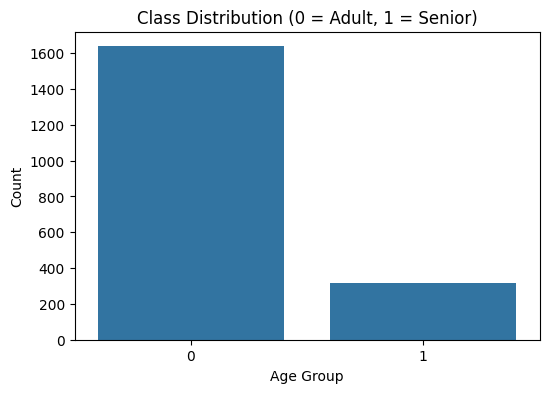

In [ ]:
# 1. Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="age_group")
plt.title("Class Distribution (0 = Adult, 1 = Senior)")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

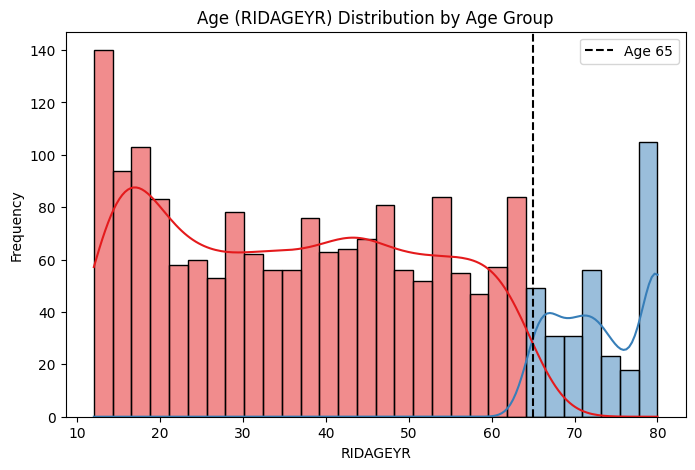

In [ ]:
# 2. RIDAGEYR (age) distribution by age_group
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="RIDAGEYR", hue="age_group", bins=30, kde=True, palette="Set1")
plt.title("Age (RIDAGEYR) Distribution by Age Group")
plt.xlabel("RIDAGEYR")
plt.ylabel("Frequency")
plt.axvline(65, color='black', linestyle='--', label="Age 65")
plt.legend()
plt.show()

/tmp/ipython-input-5-850317937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y=col, palette="Set2")


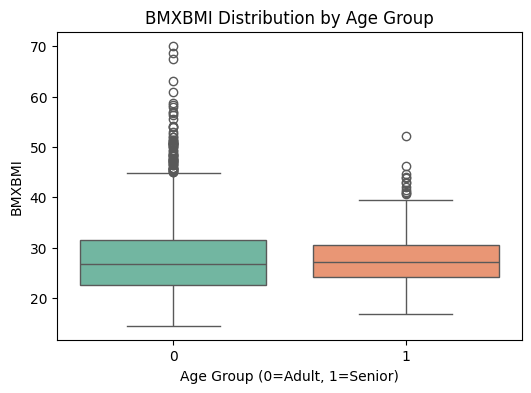

/tmp/ipython-input-5-850317937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y=col, palette="Set2")


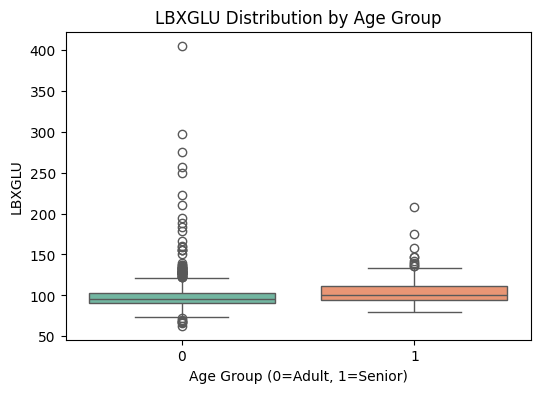

/tmp/ipython-input-5-850317937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y=col, palette="Set2")


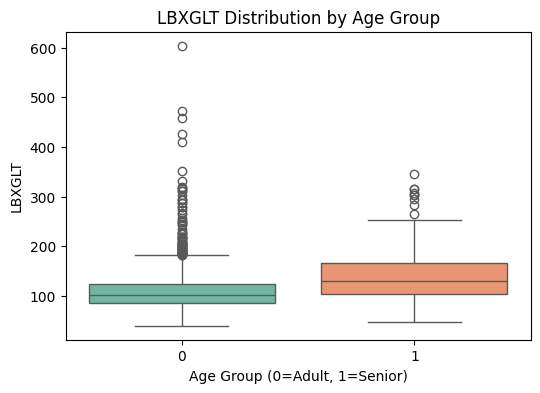

/tmp/ipython-input-5-850317937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y=col, palette="Set2")


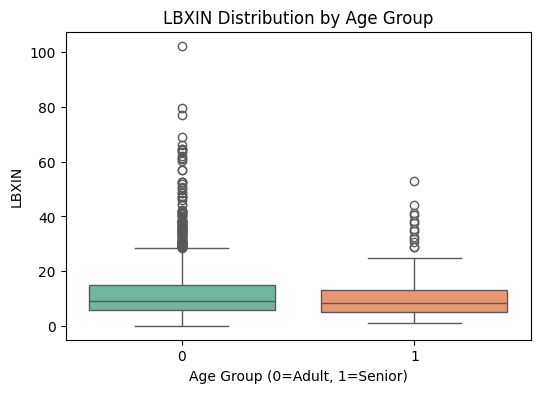

/tmp/ipython-input-5-850317937.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="age_group", y=col, palette="Set2")


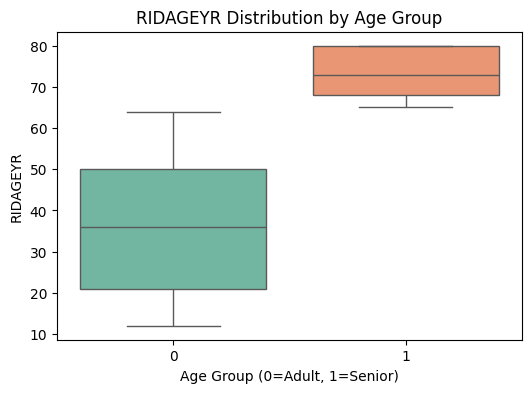

In [ ]:
# 3. Boxplots for numeric features by class
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN', 'RIDAGEYR']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x="age_group", y=col, palette="Set2")
    plt.title(f"{col} Distribution by Age Group")
    plt.xlabel("Age Group (0=Adult, 1=Senior)")
    plt.ylabel(col)
    plt.show()

In [ ]:
# 4. Missing value summary
missing_info = df.isnull().sum().to_frame("Missing Count")
missing_info["% Missing"] = (missing_info["Missing Count"] / len(df)) * 100
print(" Missing Values:\n", missing_info)

🔍 Missing Values:
            Missing Count  % Missing
SEQN                  12   0.614754
RIDAGEYR               9   0.461066
RIAGENDR              18   0.922131
PAQ605                13   0.665984
BMXBMI                18   0.922131
LBXGLU                13   0.665984
DIQ010                18   0.922131
LBXGLT                11   0.563525
LBXIN                  9   0.461066
age_group              0   0.000000


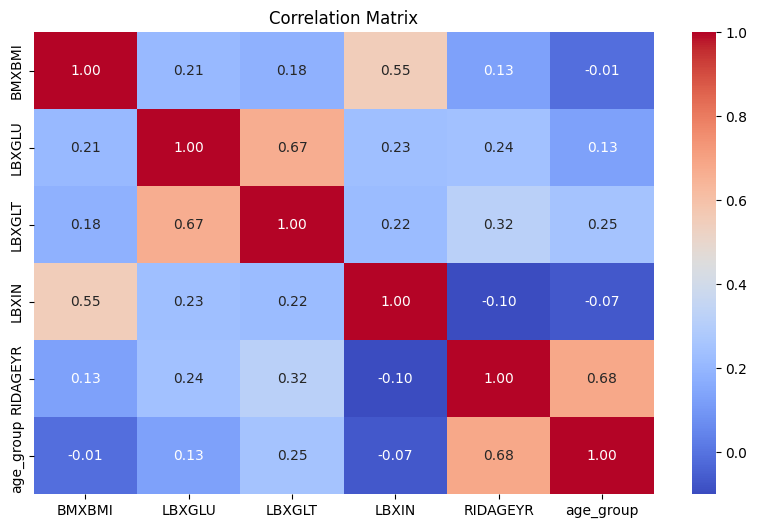

In [ ]:
# 5. Correlation matrix (numeric only)
plt.figure(figsize=(10, 6))
corr_matrix = df[num_cols + ["age_group"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Load data
train_df = pd.read_csv("/content/Train_Data.csv")
test_df = pd.read_csv("/content/Test_Data.csv")

# Drop identifier
train_df.drop(columns=["SEQN"], inplace=True, errors="ignore")
test_df.drop(columns=["SEQN"], inplace=True, errors="ignore")

# Drop rows with missing target
train_df = train_df[train_df["age_group"].notnull()]

# Encode target
train_df["age_group"] = train_df["age_group"].map({"Adult": 0, "Senior": 1})

# Separate features and target
X = train_df.drop(columns=["age_group"])
y = train_df["age_group"]
X_test = test_df.copy()

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_test_imputed = imputer.transform(X_test)

# Double-check no NaNs remain
assert not np.isnan(X_imputed).any(), "NaNs remain in training data!"
assert not np.isnan(X_test_imputed).any(), "NaNs remain in test data!"

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Threshold tuning with cross-validation
best_f1 = 0
best_thresh = 0.5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for thresh in np.arange(0.1, 0.9, 0.01):
    f1_scores = []
    for train_idx, val_idx in skf.split(X_scaled, y):
        X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = RandomForestClassifier(
            n_estimators=300, max_depth=12, class_weight='balanced', random_state=42
        )
        model.fit(X_tr, y_tr)
        y_val_probs = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_probs > thresh).astype(int)
        f1_scores.append(f1_score(y_val, y_val_pred))

    mean_f1 = np.mean(f1_scores)
    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_thresh = thresh

print(f"Best threshold: {best_thresh:.2f}, Cross-Validated F1: {best_f1:.4f}")

# Train final model
final_model = RandomForestClassifier(
    n_estimators=300, max_depth=12, class_weight='balanced', random_state=42
)
final_model.fit(X_scaled, y)
y_test_probs = final_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_probs > best_thresh).astype(int)

# Generate submission
submission = pd.DataFrame({
    "age_group": y_test_pred
})
submission.to_csv("submission.csv", index=False)
print("Final submission saved as 'submission.csv'")


/tmp/ipython-input-11-2788513188.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["age_group"] = train_df["age_group"].map({"Adult": 0, "Senior": 1})


✅ Best threshold: 0.18, Cross-Validated F1: 0.9984
Final submission saved as 'submission.csv'
